# A first attempt at training on the maria data

Here we are trying to train a transformer on the TODs directly, mapping to the CMB tod component.

## Step 1: Generate data with maria

In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt

import maria

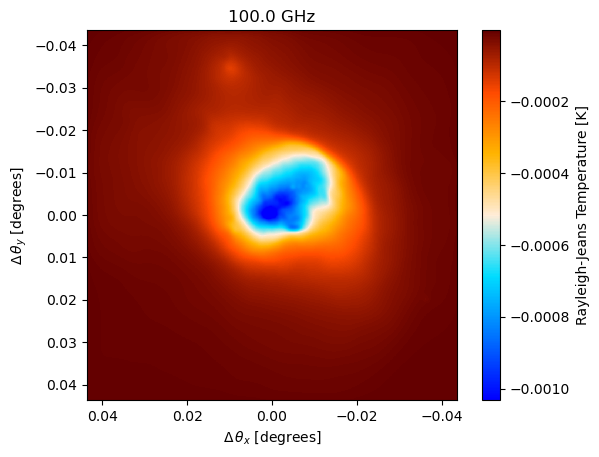

In [2]:
map_filename = maria.io.fetch("maps/cluster.fits")

# load in the map from a fits file
input_map = maria.map.read_fits(filename=map_filename, #filename
                                resolution=-8.714e-05, #pixel size in degrees
                                index=0, #index for fits file
                                center=(150, 10), # position in the sky
                                units='Jy/pixel' # Units of the input map 
                               )

input_map.to(units="K_RJ").plot()

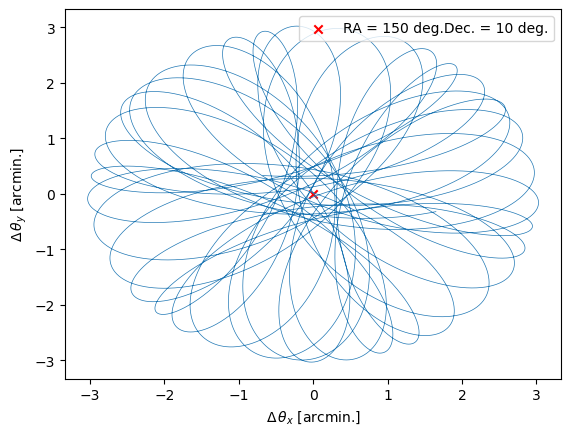

In [3]:
#load the map into maria
plan = maria.get_plan(scan_pattern="daisy", # scanning pattern
                      scan_options={"radius": 0.05, "speed": 0.01}, # in degrees
                      duration=600, # integration time in seconds
                      sample_rate=50, # in Hz
                      scan_center=(150, 10), # position in the sky
                      frame="ra_dec")

plan.plot()

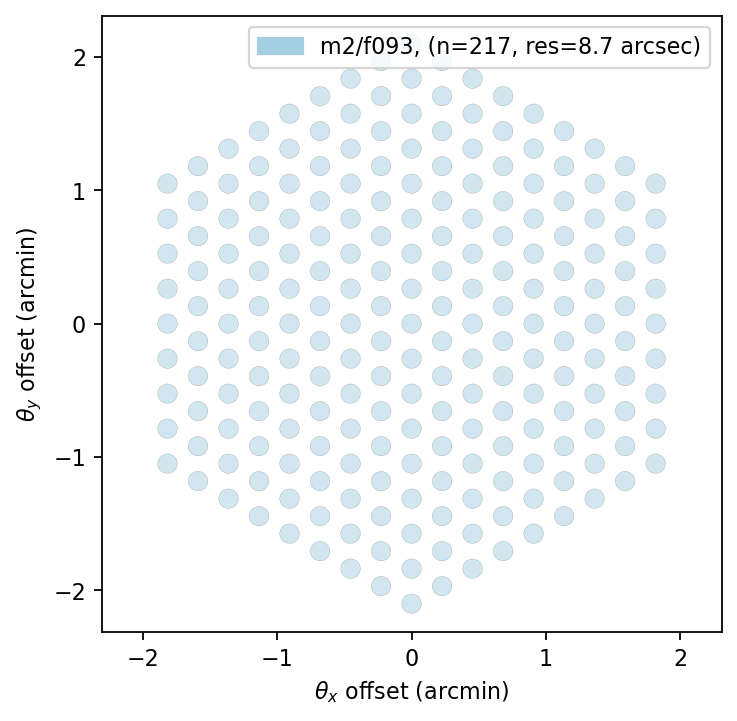

In [4]:
instrument = maria.get_instrument('MUSTANG-2')
instrument.plot()

In [5]:
sim = maria.Simulation(instrument, 
                       plan=plan,
                       site="llano_de_chajnantor", 
                       map=input_map,
                       atmosphere="2d",
                       cmb="generate",
                      )

tod = sim.run()

2024-07-12 17:49:58.344 INFO: Constructed instrument.
2024-07-12 17:49:58.345 INFO: Constructed plan.
2024-07-12 17:49:58.346 INFO: Constructed site.
2024-07-12 17:49:58.868 INFO: Constructed boresight.
2024-07-12 17:49:59.114 INFO: Constructed offsets.


Initialized base in 769 ms.


Generating CMB:   0%|          | 0/1 [00:00<?, ?it/s]2024-07-12 17:50:00.993 INFO: Sigma is 0.000000 arcmin (0.000000 rad) 
2024-07-12 17:50:00.993 INFO: -> fwhm is 0.000000 arcmin
Generating noise: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]
Generating atmosphere: 4it [00:00,  4.36it/s]
Sampling map (m2/f093): 100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


Data and components are stored in tod.components and tod.data:

In [6]:
tod.components

{'atmosphere': dask.array<array, shape=(217, 30000), dtype=float32, chunksize=(217, 30000), chunktype=numpy.ndarray>,
 'cmb': dask.array<array, shape=(217, 30000), dtype=float32, chunksize=(217, 30000), chunktype=numpy.ndarray>,
 'map': dask.array<array, shape=(217, 30000), dtype=float32, chunksize=(217, 30000), chunktype=numpy.ndarray>,
 'noise': dask.array<setitem, shape=(217, 30000), dtype=float32, chunksize=(217, 30000), chunktype=numpy.ndarray>}

In [7]:
tod.data

dask.array<add, shape=(217, 30000), dtype=float32, chunksize=(217, 30000), chunktype=numpy.ndarray>

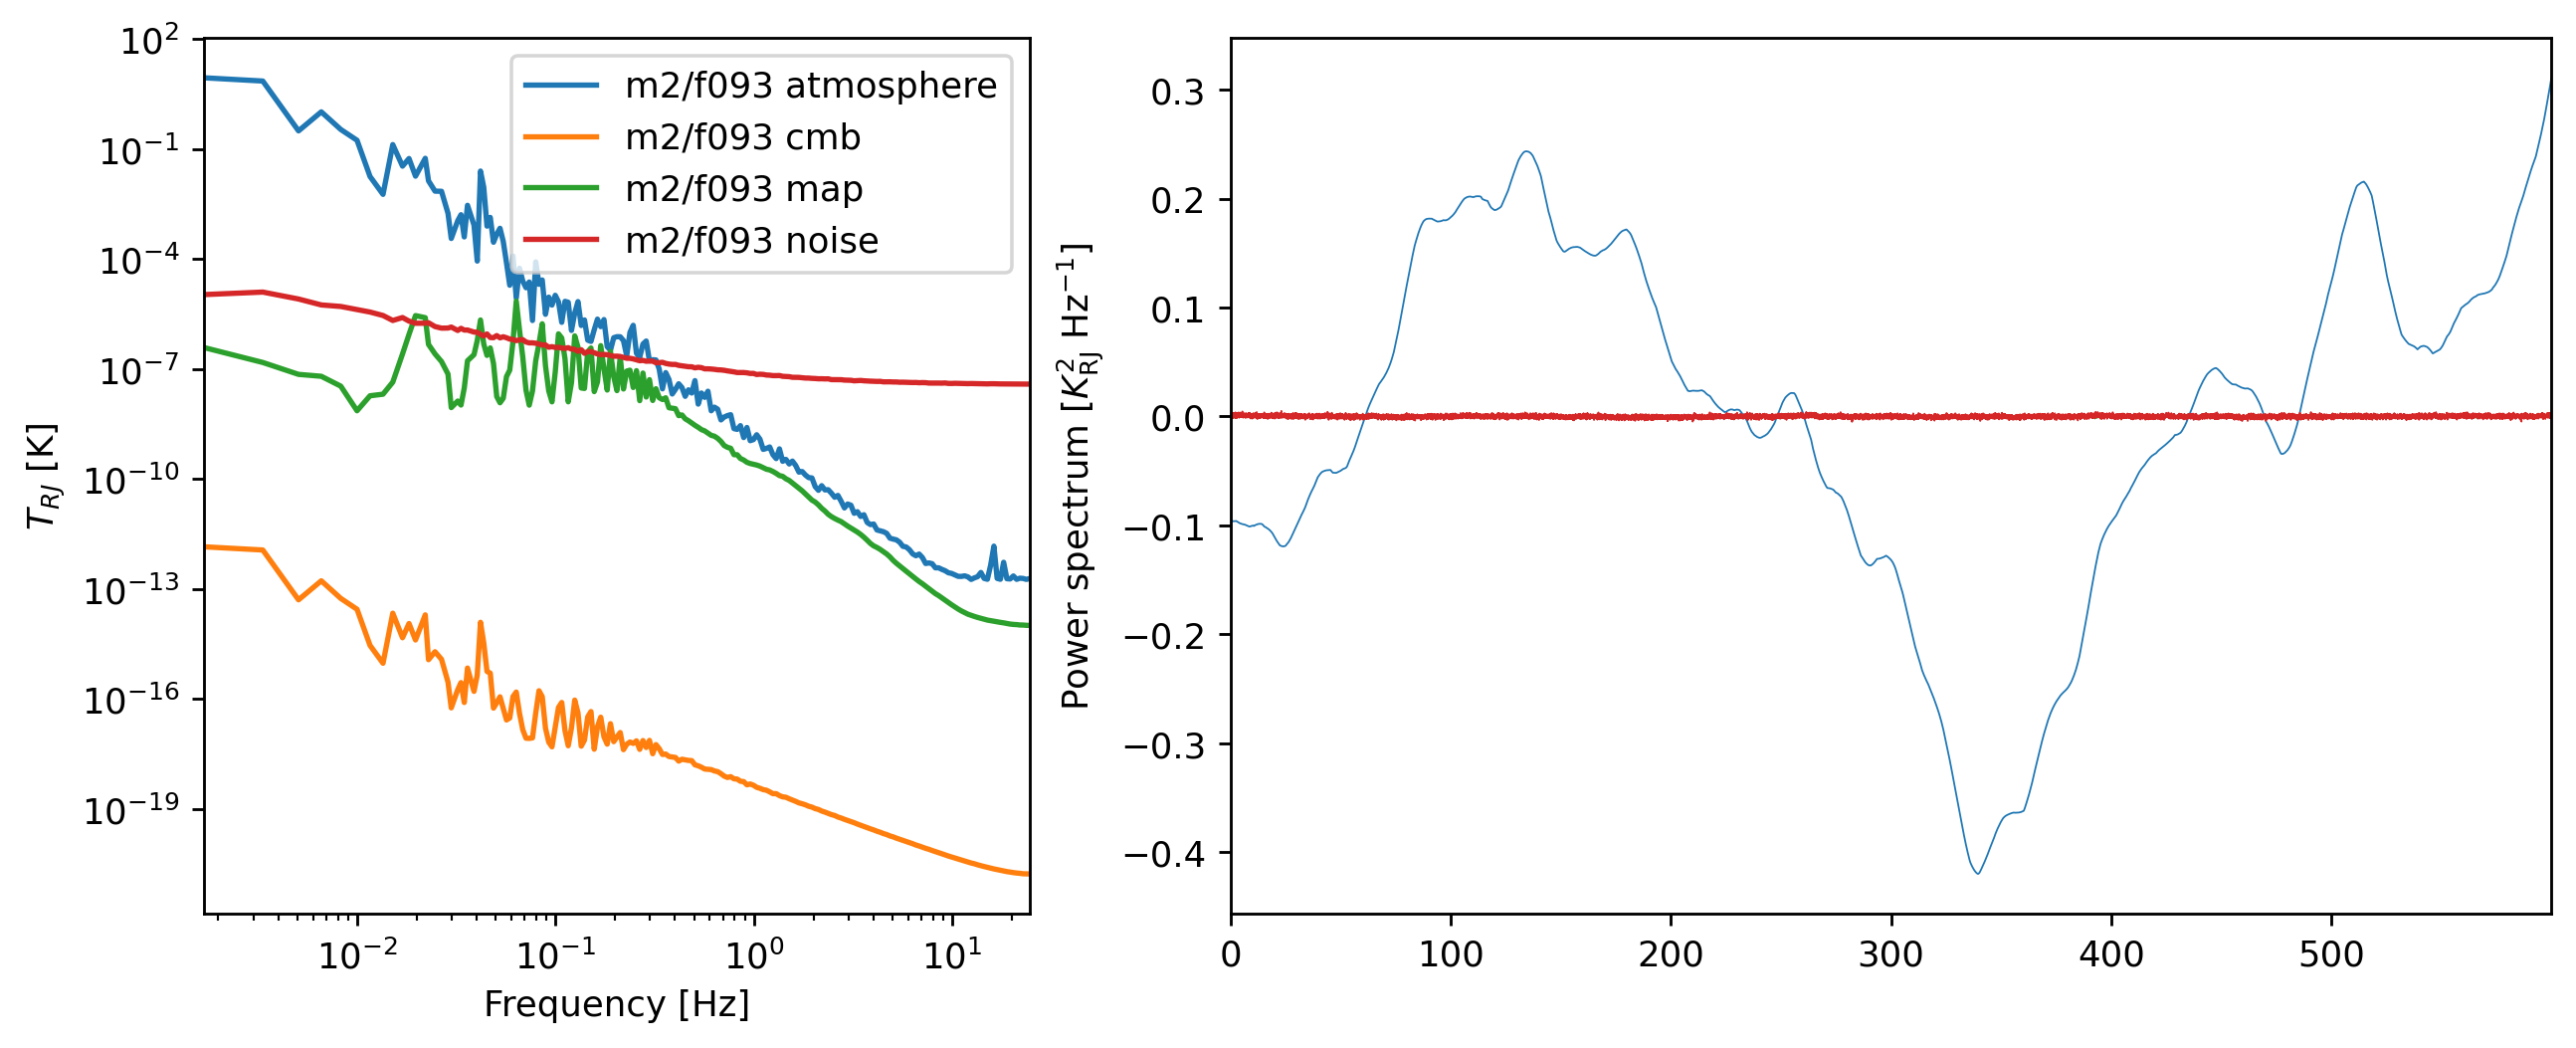

In [8]:
tod.plot(calibrate=True, detrend=True)

## Baseline reco to compare to:

baseline denoised TOD does not exist anymore?

Running mapper (m2/f093): 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


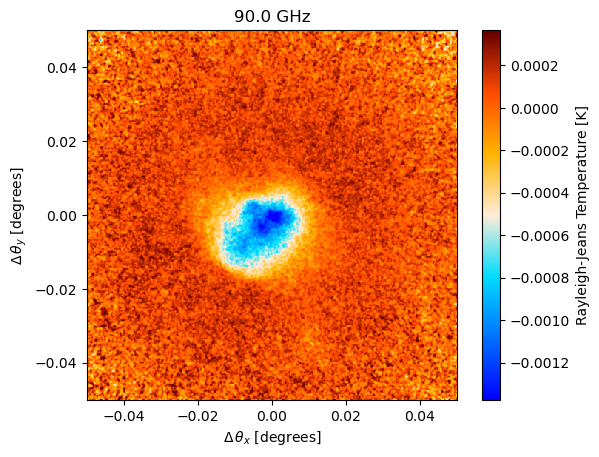

In [9]:
from maria.map.mappers import BinMapper

mapper = BinMapper(center=(150, 10), 
                   frame="ra_dec", 
                   width=0.1, 
                   height=0.1,
                   resolution=2e-4,
                   tod_postprocessing={
                        "remove_modes": {"n": 1},
                        # "highpass": {"f": 0.01},
                        "despline": {"spacing": 10},
                    },
                    map_postprocessing={
                        "gaussian_filter": {"sigma": 1},
                        "median_filter": {"size": 1},
                    },
                  )

mapper.add_tods(tod)
output_map = mapper.run()

output_map.plot()

In [10]:
# TODO: Make plot of baseline PS. Broken atm, since `mapper.DATA` does not exist anymore.
# See working: https://github.com/thomaswmorris/maria/blob/f0ea09ee2e97d70bfb07bbdfb520aa4ebd79ac55/docs/source/tutorials/MUSTANG-2_cluster.ipynb
# vs new: https://thomaswmorris.com/maria/tutorials/MUSTANG-2_cluster.html

# dt = (tod.time[1] - tod.time[0]).compute()
# data = mapper.DATA

# # visualize powerspectrum
# # -----------------------
# f, ps = sp.signal.periodogram(data, fs=1/dt, window="tukey")

# fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=256, tight_layout=True, gridspec_kw={'width_ratios': [1, 1.6]})
# fig.suptitle('Raw time streams')

# for i in range(-20,20,2): axes[0].plot(np.logspace(-7, 3,100), np.logspace(-7, 3,100) ** (-3)/1e11/(10**i), c = 'gray', alpha = 0.2, ls = '--', lw = 1)

# axes[0].plot(f[1:], ps.mean(axis=0)[1:], label="Combined", alpha = 0.7, c = 'C0', lw = 1.5, ls = '-')

# axes[0].set_xlabel(r"$\mathcal{f}$ [Hz]"), 
# axes[0].set_ylabel(r"$\mathcal{P}_{\rm Hz}[K_{\rm RJ}^2~{\rm Hz}^{-1}]$")
# axes[0].loglog()
# axes[0].legend(loc = 1, frameon=False)
# axes[0].axis(xmin=1e-2, xmax = 2e2, ymin = 1e-10, ymax = 1e2)

# axes[1].set_xlabel('Time [minutes]'), axes[1].set_ylabel("\n"+r'$I_\nu$ [$K_{\rm RJ}$]')
# axes[1].plot((tod.time - tod.time[0])/60, data[0], label = 'Real', alpha = 1., c = 'C0', lw = 1, ls = '-')
# plt.show()

## Step 2: Set up transformer

Question: How do we tokenise? Since we do already have numbers, maybe we don't need to? -> Yes!

In [11]:
def tokenize():
    return

tod.data.compute().shape

(217, 30000)

In [12]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cuda')
torch.cuda.set_device(2) # which GPU to use
torch.set_num_threads(4) # how many threads to fill workers with
print("Using device:", DEVICE)

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 128):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                #  src_vocab_size: int,
                #  tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.src_inlin = nn.Linear(217, emb_size)
        self.tgt_inlin = nn.Linear(217, emb_size)
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        # self.generator = nn.Linear(emb_size, tgt_vocab_size)
        # self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        # self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)
        self.tgt_outlin = nn.Linear(emb_size, 217)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                # src_padding_mask: Tensor,
                # tgt_padding_mask: Tensor,
                # memory_key_padding_mask: Tensor
                ):
        src_emb = self.positional_encoding(self.src_inlin(src))
        tgt_emb = self.positional_encoding(self.tgt_inlin(trg))
        
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask,
                                # src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
                                src_is_causal = False, tgt_is_causal = True)
        # return self.generator(outs)
        
        return self.tgt_outlin(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_inlin(src)), src_mask, src_is_causal = False)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_inlin(tgt)), memory, tgt_mask, tgt_is_causal = True)

Using device: cuda


In [13]:
?Transformer

Init signature:
Transformer(
    d_model: int = 512,
    nhead: int = 8,
    num_encoder_layers: int = 6,
    num_decoder_layers: int = 6,
    dim_feedforward: int = 2048,
    dropout: float = 0.1,
    activation: Union[str, Callable[[torch.Tensor], torch.Tensor]] = <function relu at 0x7fd3bb54ade0>,
    custom_encoder: Optional[Any] = None,
    custom_decoder: Optional[Any] = None,
    layer_norm_eps: float = 1e-05,
    batch_first: bool = False,
    norm_first: bool = False,
    bias: bool = True,
    device=None,
    dtype=None,
) -> None
Docstring:     
A transformer model.

User is able to modify the attributes as needed. The architecture
is based on the paper "Attention Is All You Need". Ashish Vaswani, Noam Shazeer,
Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez, Lukasz Kaiser, and
Illia Polosukhin. 2017. Attention is all you need. In Advances in Neural Information
Processing Systems, pages 6000-6010.

Args:
    d_model: the number of expected features in the encoder/d

In [14]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    # src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    # tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    # return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask
    return src_mask, tgt_mask

In [15]:
torch.manual_seed(0)

# SRC_VOCAB_SIZE = len(vocab_transform[SRC_DATA])
# SRC_VOCAB_SIZE = int(len(torch.tensor(tod.data.compute()).reshape(-1, 1))/1e4)
# TGT_VOCAB_SIZE = int(len(torch.tensor(tod.data.compute()).reshape(-1, 1))/1e4)
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

# loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
# loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

/scratch/users/jwuerzin/miniconda3/envs/maria/lib/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [16]:
tod = sim.run()

Generating noise:   0%|          | 0/1 [00:00<?, ?it/s]

Generating noise: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]
Generating atmosphere: 4it [00:00,  4.98it/s]
Sampling map (m2/f093): 100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


In [17]:
tod.data.compute().shape

(217, 30000)

In [18]:
def give_batch(xdata: torch.Tensor, cmbdata: torch.Tensor, batch_size: int = 512, seq_len: int = 128):
    '''Makes batch_size batches with size seq_len from xdata and cmbdata.
    Returns in shape (seq_len, batch_size, 217).
    '''
    
    i_start = torch.randint(0, 30_000-seq_len, size=(batch_size,))
    
    xdata_i = torch.hstack([xdata[ii:ii+seq_len][:,None] for ii in i_start])
    cmbdata_i = torch.hstack([cmbdata[ii:ii+seq_len][:,None] for ii in i_start])
    
    return xdata_i, cmbdata_i

give_batch(torch.Tensor(tod.data.compute().T), torch.Tensor(tod.components['cmb'].compute().T))

(tensor([[[12.1229, 12.1228, 12.1231,  ..., 12.1260, 12.1211, 12.1247],
          [12.2660, 12.2664, 12.2657,  ..., 12.2693, 12.2641, 12.2682],
          [12.0984, 12.0984, 12.0983,  ..., 12.1010, 12.0957, 12.1003],
          ...,
          [12.2631, 12.2634, 12.2632,  ..., 12.2661, 12.2616, 12.2649],
          [12.1072, 12.1075, 12.1070,  ..., 12.1101, 12.1050, 12.1090],
          [12.1239, 12.1236, 12.1232,  ..., 12.1269, 12.1209, 12.1254]],
 
         [[12.1231, 12.1231, 12.1228,  ..., 12.1268, 12.1211, 12.1250],
          [12.2660, 12.2669, 12.2657,  ..., 12.2696, 12.2638, 12.2681],
          [12.0982, 12.0983, 12.0977,  ..., 12.1013, 12.0960, 12.1003],
          ...,
          [12.2627, 12.2641, 12.2632,  ..., 12.2666, 12.2615, 12.2652],
          [12.1071, 12.1075, 12.1066,  ..., 12.1103, 12.1050, 12.1090],
          [12.1234, 12.1231, 12.1234,  ..., 12.1265, 12.1212, 12.1251]],
 
         [[12.1231, 12.1232, 12.1229,  ..., 12.1263, 12.1212, 12.1253],
          [12.2658, 12.2664,

In [27]:
from torch.utils.data import DataLoader

def train_epoch(model, optimizer, xdata, cmbdata):
    model.train()
    losses = 0
    # train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    # train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    # for src, tgt in train_dataloader:
    
    # for i in range(30_000//BATCH_SIZE):
    for i in range(10):
        print("HERE", i, 30_000//BATCH_SIZE)
        src, tgt = give_batch(xdata=xdata, cmbdata=cmbdata) # TODO: Too slow! Needs to be vectorised!!
        
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        # src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        src_mask, tgt_mask = create_mask(src, tgt_input)

        # logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
        logits = model(src, tgt_input, src_mask, tgt_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        # loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1)) #TODO: sizes mismatched here!
        loss = loss_fn(logits.reshape(-1), tgt_out.reshape(-1)) 
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / xdata.shape[0]

In [28]:
from timeit import default_timer as timer
import matplotlib.pyplot as plt
NUM_EPOCHS = 18
# NUM_EPOCHS = 1

train_losses = []
val_losses = []

xdata = torch.Tensor(tod.data.compute().T)
cmbdata = torch.Tensor(tod.components['cmb'].compute().T)

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer, xdata, cmbdata)
    end_time = timer()
    # val_loss = evaluate(transformer)
    
    train_losses += [train_loss,]
    # val_losses += [val_loss,]
    # print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

HERE 0 234
HERE 1 234
HERE 2 234
HERE 3 234
HERE 4 234
HERE 5 234
HERE 6 234
HERE 7 234
HERE 8 234
HERE 9 234
Epoch: 1, Train loss: 0.000, Epoch time = 2.463s
HERE 0 234
HERE 1 234
HERE 2 234
HERE 3 234
HERE 4 234
HERE 5 234
HERE 6 234
HERE 7 234
HERE 8 234
HERE 9 234
Epoch: 2, Train loss: 0.000, Epoch time = 2.467s
HERE 0 234
HERE 1 234
HERE 2 234
HERE 3 234
HERE 4 234
HERE 5 234
HERE 6 234
HERE 7 234
HERE 8 234
HERE 9 234
Epoch: 3, Train loss: 0.000, Epoch time = 2.477s
HERE 0 234
HERE 1 234
HERE 2 234
HERE 3 234
HERE 4 234
HERE 5 234
HERE 6 234
HERE 7 234
HERE 8 234
HERE 9 234
Epoch: 4, Train loss: 0.000, Epoch time = 2.453s
HERE 0 234
HERE 1 234
HERE 2 234
HERE 3 234
HERE 4 234
HERE 5 234
HERE 6 234
HERE 7 234
HERE 8 234
HERE 9 234
Epoch: 5, Train loss: 0.000, Epoch time = 2.470s
HERE 0 234
HERE 1 234
HERE 2 234
HERE 3 234
HERE 4 234
HERE 5 234
HERE 6 234
HERE 7 234
HERE 8 234
HERE 9 234
Epoch: 6, Train loss: 0.000, Epoch time = 2.474s
HERE 0 234
HERE 1 234
HERE 2 234
HERE 3 234
HE

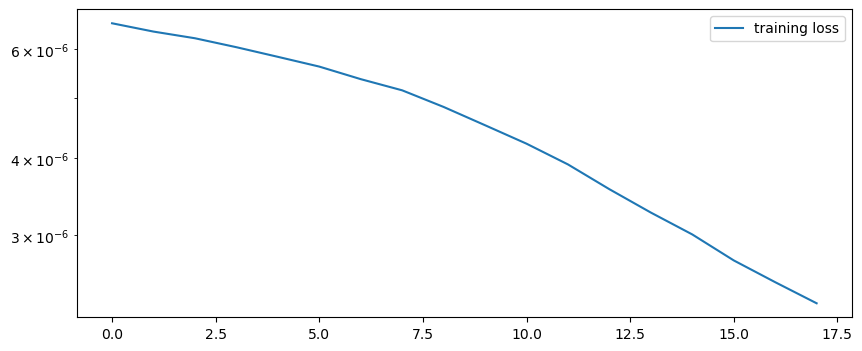

In [29]:
fig, axes = plt.subplots(1, 1, figsize=(10,4))
axes.plot(train_losses, label='training loss')
# axes.plot(val_losses, label='val_losses')
plt.legend()
plt.yscale('log')
plt.show()

In [ ]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    print("HERE4!!!!", memory)
    ys = torch.ones(1, 1).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        # if next_word == EOS_IDX:
        #     break
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src: str):
    model.eval()
    # src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    print("HERE!!!!")
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    print("HERE2!!!!")
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5).flatten()
    print("HERE3!!!!")
    # return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")
    return tgt_tokens

In [ ]:
# src = torch.randint(0, 10, (100, 100))
src = torch.randint(0, 10, (10,))
print(src)
translate(transformer, src)

tensor([9, 5, 1, 9, 6, 8, 9, 4, 7, 1])
HERE!!!!
HERE2!!!!
HERE4!!!! 

tensor([[[-2.4759,  1.1274, -0.4371,  ..., -0.1905, -0.0903,  0.6265],
         [-2.8059,  1.5785, -0.7094,  ...,  0.5847,  0.0695,  0.5440],
         [-1.6273,  0.3424,  0.5490,  ..., -0.0945, -0.9647,  0.6910],
         ...,
         [-2.1106,  1.2475, -0.2973,  ...,  0.6842, -0.1878,  0.7608],
         [-2.1549,  1.3235, -0.1828,  ...,  1.3358, -0.8860,  0.2073],
         [-1.6273,  0.3424,  0.5490,  ..., -0.0945, -0.9647,  0.6910]],

        [[-2.3799,  1.0544, -0.3073,  ..., -0.1875, -0.1972,  0.6759],
         [-2.7199,  1.5192, -0.6541,  ...,  0.6175, -0.0089,  0.5649],
         [-1.4925,  0.3105,  0.7292,  ..., -0.0839, -1.0761,  0.7199],
         ...,
         [-2.0030,  1.1775, -0.2077,  ...,  0.7031, -0.2949,  0.7942],
         [-2.0572,  1.2631, -0.1069,  ...,  1.4050, -0.9360,  0.2480],
         [-1.4925,  0.3105,  0.7292,  ..., -0.0839, -1.0761,  0.7199]],

        [[-2.3883,  0.9218, -0.2583,  ..., -0.1879, -0.2298,  0.6875],
         [-2.7271,  1.3944, -0.6379,  ...,  0

RuntimeError: shape '[10, 8, 64]' is invalid for input of size 51200